In [2]:
import glob
import os
import pickle
import sys
from pathlib import Path
import random
from tqdm import tqdm

import torchvision.models as models
from torch.nn import Module, Dropout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import torchvision



from torchvision import datasets, models, transforms
import time
import logging

#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import KFold
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV



In [8]:
train_transforms = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(brightness=0, contrast=0, saturation=1, hue=.5),
                                    transforms.ToTensor()])


val_transforms= transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor()])


# cross validaion with 5 folders on the train 
train_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/train', train_transforms) 

# cross validaion with 5 folders on the val 
val_dataset = datasets.ImageFolder('/Users/eudari01/GNNs_Vs_CNNs/tiles_CIN/val', val_transforms) 


batch_size = 48
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
valid_loader= torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=16, shuffle=True)

                         

In [9]:
# Cross validation

#dataset = ConcatDataset([train_dataset, val_dataset])

#k_folds = 5

#splits = KFold(n_splits=k_folds, shuffle=True)

#train_ids, valid_ids = train_test_split(range(len(dataset)), test_size=0.3)

In [10]:
#for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    
    # Sample elements randomly from a given list of ids, no replacement.
    
    #train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    
    #val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    # Define data loaders for training and testing data in this fold
    #train_loader = torch.utils.data.DataLoader(
                      #dataset, 
                      #batch_size=48, sampler=train_subsampler)
    #val_loader = torch.utils.data.DataLoader(
                      #dataset,
                      #batch_size=48, sampler=val_subsampler)

In [11]:
#len(train_dataset)

In [12]:
#chesk the classes 
#len(train_dataset)
#len(val_dataset)

In [107]:
#model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)

In [108]:
#model.eval()

In [13]:
class VGG_19(Module):
    
    def __init__(self):
        
        model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)
        
        super(VGG_19,self).__init__()
        self.model= model
        self.Regression = nn.Linear(1000,1)
        self.dropout = Dropout(0.5)
        
           
         
    def forward(self, out):
        
        x= self.model(out)
        
        x = x.view(x.size(0), -1) # flatten
        
        x = self.dropout(x)
        
        x =self.Regression(x)
        
        return x

In [27]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Model = models.vgg19(pretrained=True).features.to(device).eval()

In [14]:
Model= VGG_19()
MSE = torch.nn.MSELoss()
optimizer = torch.optim.SGD(Model.parameters(), lr=0.00001,momentum=0.9)


Using cache found in /Users/eudari01/.cache/torch/hub/pytorch_vision_v0.10.0


In [15]:
#train_accuracy=[]
train_loss = []


def train (epoch):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    #train_sum_of_squared_error = 0.0
   
    
    
    for data1, label1 in tqdm(train_loader):
        
            label1= label1.to(torch.float32)
            label1 = label1.unsqueeze(1)

         
        #Transfer Data to GPU if available
        #if torch.cuda.is_available():
            #data = data.cuda()
            #label = label.cuda()
            Model.train()
            output = Model(data1)
            #you can change the loss and use MSE or Cross Entropy
            loss = MSE(output,label1)
           
            # Clear the gradients
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            #Calculate accuracy 
            prediction_train=output.argmax(dim=1)
            
            
            acc = (prediction_train== label1).float().mean()
            

            running_loss_train =+ loss.item()* data1.size(0) 
            #Epoch
            epoch_accuracy += acc.item() / len(train_loader)
            epoch_loss += running_loss_train / len(train_loader)
            
            
            
            
    train_loss.append(epoch_loss)
    #train_accuracy.append(epoch_accuracy)
               
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} \n")

In [16]:
#val_accuracy=[]

val_loss = []
def validation (epoch):
    
    
     #with torch.no_grad():
        
        epoch_val_accuracy = 0.0
        epoch_val_loss = 0.0
        #val_sum_of_squared_error= 0.0
        Model.eval()

        for data, label in valid_loader:
            #if torch.cuda.is_available():
                
               # data = data.cuda()
                #label = label.cuda()
                label= label.to(torch.float32)
                label = label.unsqueeze(1)
    
                val_output = Model(data)
                
                loss = MSE(val_output, label)
                
                # Clear the gradients
                optimizer.zero_grad()
                
                #val_loss.backward()
                
                #optimizer.step()
                #Calculate accuracy 
                prediction_val= val_output.argmax(dim=1)
                
                #mse_val=mean_squared_error(label,prediction_val)
                
                val_acc = (prediction_val == label).float().mean()
                
                running_loss_val =+ loss.item()* data.size(0) 
               
                #Epoch
                epoch_val_accuracy += val_acc.item() / len(valid_loader)
                epoch_val_loss += running_loss_val / len(valid_loader)

                
                #y_true_val=label.detach().numpy()
                #y_pred_val=prediction_val.detach().numpy()
               # mse_val=mean_squared_error(y_true_val, y_pred_val, squared=False)
        #val_accuracy.append(epoch_val_accuracy)
  
        val_loss.append(epoch_val_loss)
                
                
                
        print(
          f"Epoch : {epoch+1} - va_loss : {epoch_val_loss:.4f} \n")

In [17]:
epochs=30
for epoch in range(1,epochs+1): 
        train(epoch)
        validation(epoch)


100%|███████████████████████████████████████████| 61/61 [10:06<00:00,  9.94s/it]

Epoch : 2 - loss : 207.7449 



KeyboardInterrupt: 

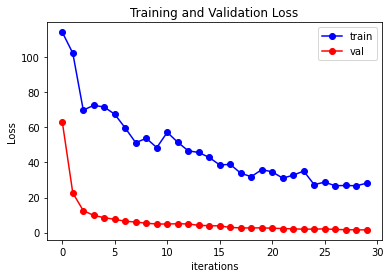

In [32]:
# to check the overfiting 
plt.title("Training and Validation Loss")
plt.plot(train_loss, 'bo-',label="train")
plt.plot(val_loss, 'ro-',label="val")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
#plt.save
plt.show()

Hyperparameter tuning

In [43]:
param_grid = {'lr': [1e-6,1.0],  
              'momentum': [0.1,2], 
              'batch_size':[10, 20, 40, 60, 80, 100],
              }  
grid = GridSearchCV(Model, param_grid, refit = True, verbose = 3,n_jobs=-1) 
#grid.fit(data1,label1)
#grid.best_params_

TypeError: estimator should be an estimator implementing 'fit' method, VGG_19(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (16): ReLU(inplace=True)
      (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (18): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (19): ReLU(inplace=True)
      (20): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (21): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (22): ReLU(inplace=True)
      (23): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (24): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (25): ReLU(inplace=True)
      (26): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (27): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (28): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (29): ReLU(inplace=True)
      (30): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (31): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (32): ReLU(inplace=True)
      (33): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (34): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (35): ReLU(inplace=True)
      (36): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (37): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (38): ReLU(inplace=True)
      (39): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (40): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (41): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (42): ReLU(inplace=True)
      (43): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (44): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (45): ReLU(inplace=True)
      (46): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (47): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (48): ReLU(inplace=True)
      (49): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (50): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (51): ReLU(inplace=True)
      (52): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
    (classifier): Sequential(
      (0): Linear(in_features=25088, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_features=4096, out_features=4096, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.5, inplace=False)
      (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
  )
  (Regression): Linear(in_features=1000, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
) was passed